In [43]:
# импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

In [44]:
# читаем Excel-файл
df = pd.read_excel("Dataset 1.xlsx", sheet_name="RZD_news")

In [45]:
# исключаем строки, где оператор — АО "ПГК"
df = df[df["Оператор"] != 'АО "ПГК"']

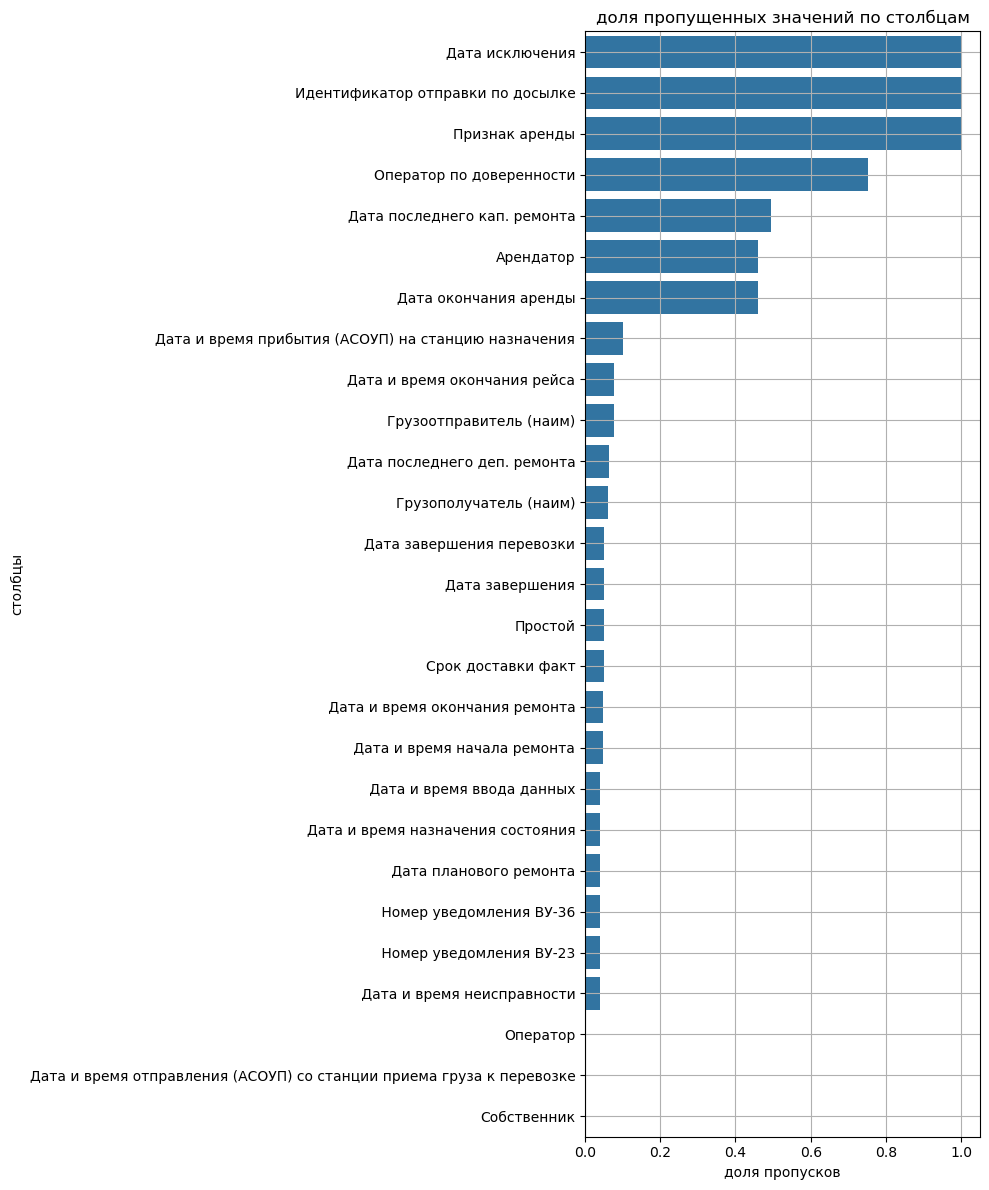

In [46]:
# глянем какие столбцы содержат пропущенные значения
missing_values = df.isnull().mean().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]  # убираем нули

# рисуем график
plt.figure(figsize=(10, 12))
sns.barplot(x=missing_values.values, y=missing_values.index)
plt.title("доля пропущенных значений по столбцам")
plt.xlabel("доля пропусков")
plt.ylabel("столбцы")
plt.grid(True)
plt.tight_layout()
plt.show()


# на графике видно, что в некоторых столбцах много пропусков — например, в Дата и время окончания рейса, Срок доставки факт, Дата завершения перевозки и т.д.
# это нормально для логистики — не все рейсы могут быть завершены на момент выгрузки данных.

In [47]:
# удалим столбцы, в которых больше половины значений — пропущенные

# сначала считаем долю пропусков по каждому столбцу
missing_ratio = df.isnull().mean()

# фильтруем только те, где больше 0.5 (то есть 50%)
cols_to_drop = missing_ratio[missing_ratio > 0.5].index

# и теперь удаляем эти столбцы из датафрейма
df = df.drop(columns=cols_to_drop)

# на всякий случай выведем, что именно удалили
print("удалены столбцы с пропусками > 50%:")
print(list(cols_to_drop))

# также удалим столбцы без целевой переменной
df = df.dropna(subset=["Срок доставки факт"])

удалены столбцы с пропусками > 50%:
['Идентификатор отправки по досылке', 'Дата исключения', 'Признак аренды', 'Оператор по доверенности']


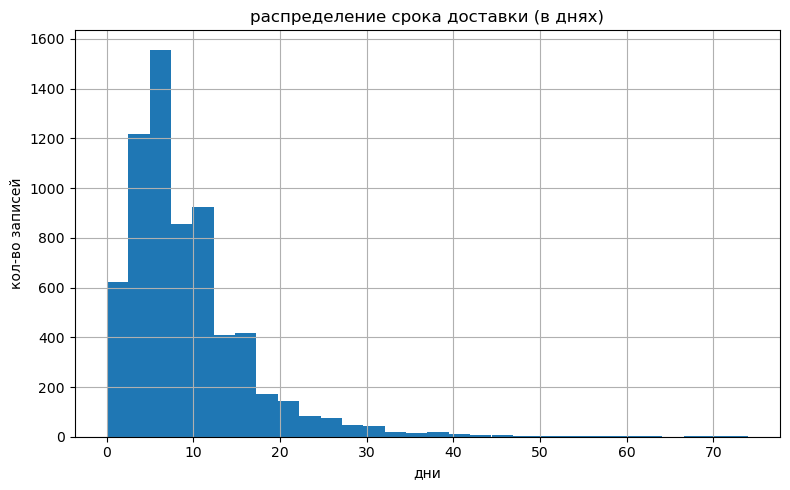

In [48]:
# смотрим как распределён срок доставки
plt.figure(figsize=(8, 5))
df["Срок доставки факт"].dropna().hist(bins=30)  # убираем пропуски, чтобы не мешались
plt.title("распределение срока доставки (в днях)")
plt.xlabel("дни")
plt.ylabel("кол-во записей")
plt.grid(True)
plt.tight_layout()
plt.show()


# распределение явно несимметричное — много доставок укладываются в 5–10 дней, но есть и хвост вправо, где сроки сильно больше.

In [49]:
# с помощью catboost определим 15 самых важных фич для целевой переменной.
# выбор catboost позволяет удобно работать сразу и с числовыми и с категориальными числами


# разделим на признаки и таргет
X = df.drop(columns=["Срок доставки факт"])
y = df["Срок доставки факт"]

# catboost не умеет работать с пустыми датами, так что найдём все datetime-колонки
datetime_cols = X.select_dtypes(include=["datetime64"]).columns.tolist()

# и заменим их на timestamp
X[datetime_cols] = X[datetime_cols].fillna(pd.Timestamp("1970-01-01"))
X[datetime_cols] = X[datetime_cols].astype(str)

# определим категориальные признаки
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

# преобразуем все категориальные признаки в строки (и NaN в 'missing')
for col in cat_features:
    X[col] = X[col].astype(str).fillna("missing")

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# создаём Pool для CatBoost
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# обучаем модель
model = CatBoostRegressor(verbose=100, random_state=42)
model.fit(train_pool)

# смотрим важность признаков
feature_importance = model.get_feature_importance(prettified=True)
print(feature_importance.head(15))  # можно больше, если хочешь

Learning rate set to 0.053348
0:	learn: 7.2665767	total: 45.6ms	remaining: 45.6s
100:	learn: 4.3382981	total: 5.26s	remaining: 46.9s
200:	learn: 3.8136248	total: 10.5s	remaining: 41.8s
300:	learn: 3.5021723	total: 16s	remaining: 37.1s
400:	learn: 3.2933302	total: 21.4s	remaining: 32s
500:	learn: 3.1011160	total: 27.2s	remaining: 27.1s
600:	learn: 2.9661197	total: 33.2s	remaining: 22s
700:	learn: 2.8321325	total: 38.9s	remaining: 16.6s
800:	learn: 2.7090629	total: 44.5s	remaining: 11.1s
900:	learn: 2.6128069	total: 50.3s	remaining: 5.52s
999:	learn: 2.5150281	total: 55.9s	remaining: 0us
                                           Feature Id  Importances
0                             Идентификатор накладной    13.451698
1                                     Дата завершения    10.896827
2                                         Дата начала     9.807936
3                               Расстояние общее (км)     7.947471
4                          Расстояние пройденное (км)     6.746563
5    

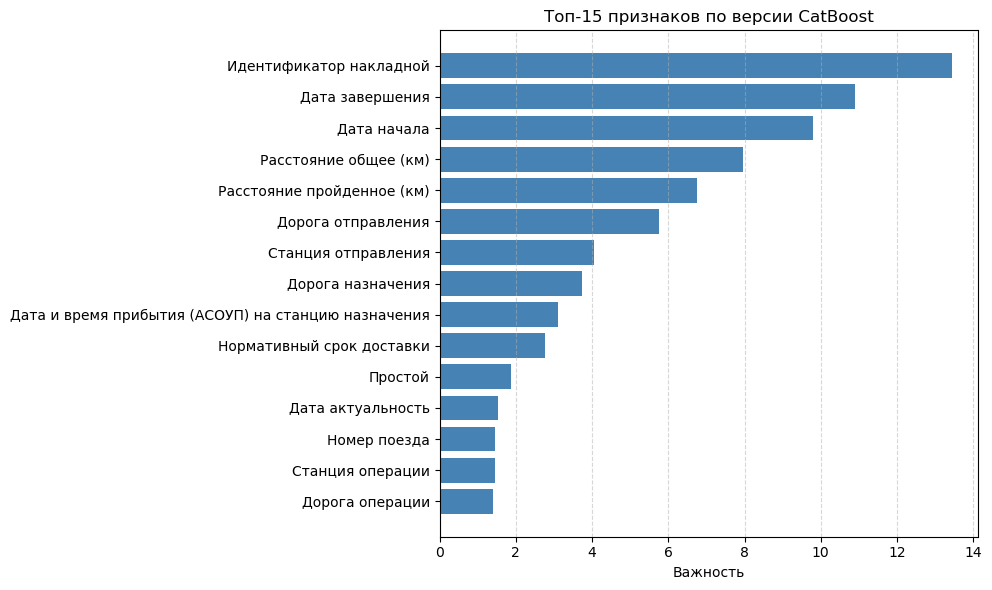

In [50]:
import matplotlib.pyplot as plt

# отберём топ-15 признаков по важности
top_n = 15
top_features = feature_importance.head(top_n)

# создаём горизонтальный bar-график
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature Id'], top_features['Importances'], color='steelblue')
plt.xlabel("Важность")
plt.title(f"Топ-{top_n} признаков по версии CatBoost")
plt.gca().invert_yaxis()  # важные вверху
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [51]:
# список признаков из top-15 по важности и целевого признака
top_features = [
    "Идентификатор накладной", "Дата завершения", "Дата начала",
    "Расстояние общее (км)", "Расстояние пройденное (км)",
    "Дорога отправления", "Станция отправления", "Дорога назначения",
    "Дата и время прибытия (АСОУП) на станцию назначения",
    "Нормативный срок доставки", "Простой", "Дата актуальность",
    "Номер поезда", "Станция операции", "Дорога операции", "Срок доставки факт"
]

# считаем количество уникальных значений
unique_counts = {
    feature: df[feature].nunique() for feature in top_features if feature in df.columns
}

# превращаем в датафрейм для удобства
unique_counts_df = pd.DataFrame.from_dict(unique_counts, orient="index", columns=["Кол-во уникальных значений"])
unique_counts_df.index.name = "Признак"

# выводим
unique_counts_df.sort_values(by="Кол-во уникальных значений", ascending=False)

,Кол-во уникальных значений
Признак,
Идентификатор накладной,6539
Дата и время прибытия (АСОУП) на станцию назначения,2784
Номер поезда,904
Расстояние общее (км),526
Расстояние пройденное (км),521
Станция отправления,431
Дата начала,232
Нормативный срок доставки,221
Дата завершения,213


In [52]:
# удаляем уникальные идентификаторы

df = df.drop(columns=[
    "Номер накладной", "Номер вагона", "Идентификатор накладной", "Номер поезда"
], errors="ignore")

# удаляем признак "Дата и время прибытия (АСОУП) на станцию назначения", 
# так как он почти копирует признак "Дата завершения" и в нашей модели не будет играть роли

df = df.drop(columns=[
    "Дата и время прибытия (АСОУП) на станцию назначения"
], errors="ignore")


In [53]:
# Признаки "Расстояние общее (км)" и "Расстояние пройденное (км)" по сути дублируют друг друга
# Проверим, так ли это
mask = df["Расстояние пройденное (км)"] != df["Расстояние общее (км)"]
print("Несовпадений:", mask.sum())

# У нас в датафрейсе 187 строк, в которых общее расстояние не равно пройденному расстоянию
# Это могло бы быть корректным, если бы в наших данных содержались незаконченные рейсы,
# но таковых у нас нет. Следовательно, данные неправильные. Проверим, какая доля подобных данных в нашем датафрейме

print("Из общего:", len(df), f"({mask.sum() / len(df) * 100:.2f}%)")

# 2.8% данных - небольшая часть, так что может удалить их, чтобы в датафрейме содержались только корректные данные
df = df[~mask].copy()

# После того, как мы удалили некорректные наблюдения, можно удалить одну из переменных, так как они все-таки дублируют друг друга
df = df.drop(columns=["Расстояние пройденное (км)"], errors="ignore")


Несовпадений: 187
Из общего: 6674 (2.80%)


In [54]:
# Признак дата завершения по сути равен дате начала + срок доставки факт, следовательно он не имеет смысла
# удалим его
df = df.drop(columns=["Дата завершения"])


In [55]:
# Признак дата актуальности - говорит о том, на какой момент времени данные актуальны.
# Если вдруг эта дата будет раньше, чем конец рейса - данные можно будет считать неактуальными
# проверим, что такого не происходит в нашем датафрейме
# сначала убедимся, что типы корректные
df["Дата начала"] = pd.to_datetime(df["Дата начала"], errors="coerce")
df["Дата актуальность"] = pd.to_datetime(df["Дата актуальность"], errors="coerce")

# считаем теоретическую дату завершения = дата начала + срок доставки
df["Предполагаемая дата завершения"] = df["Дата начала"] + pd.to_timedelta(df["Срок доставки факт"], unit="D")

# создаём маску, где предполагаемая дата завершения >= дата актуальности
mask = df["Предполагаемая дата завершения"] >= df["Дата актуальность"]

# выводим результат
print(f"Количество строк, где завершение > актуальности: {mask.sum()} из {len(df)} ({(mask.sum() / len(df)) * 100:.2f}%)")

# Расхождения есть, но их немного. Удалим подобные строки и сам признак "Дата актуальность"

df = df[~mask].copy()

df = df.drop(columns=["Дата актуальность"])
df = df.drop(columns=["Предполагаемая дата завершения"])

Количество строк, где завершение > актуальности: 113 из 6487 (1.74%)


In [56]:
df.head()

,Род вагона,Администрация собственника,Дата и время начала рейса,Государство отправления,Дорога отправления,Станция отправления,Дата и время окончания рейса,Государство назначения,Дорога назначения,Станция назначения,...,Дата и время окончания ремонта,Станция передачи-отцепки,Номер уведомления ВУ-23,Номер уведомления ВУ-36,Перевозка завершена,Оператор,Дата завершения перевозки,Срок доставки факт,Простой,Дата начала
2,Крытые (20),РЖД (20),2024-02-15 22:23:00,МОНГОЛИЯ,Восточно-Сибирская (92),Наушки (Эксп.Убжд:Улаанбаатар И Далее) (937107),NaT,Российская Федерация (643),Восточно-Сибирская (92),Залари (930409),...,2024-01-20 16:33:00,БАРНАУЛ (840109),1142.0,123.0,False,"ООО ""ГРУППА ""ПРОДОВОЛЬСТВИЕ""",2024-02-20 15:09:00,5.0,1.0,2024-02-15
4,Крытые (20),РЖД (20),2024-02-11 15:01:00,МОНГОЛИЯ,Восточно-Сибирская (92),Наушки (Эксп.Убжд: С.Баатар-У.Бат(Искл) (937003),2024-02-19 11:30:00,Российская Федерация (643),Восточно-Сибирская (92),Залари (930409),...,2022-06-07 12:15:00,АЧИНСК 2 (883809),260.0,290.0,False,"ООО ""ГРУППА ""ПРОДОВОЛЬСТВИЕ""",2024-02-19 11:30:00,8.0,2.0,2024-02-11
24,Крытые (20),РЖД (20),2024-01-19 16:09:00,Российская Федерация,Северо-Кавказская (51),Шедок (535907),2024-01-28 03:46:00,Российская Федерация (643),Южно-Уральская (80),Металлургическая (801208),...,2023-11-23 16:11:00,ЮДИНО (250001),631.0,78.0,False,"АО ""ЕВРОСИБ СПБ-ТС""",2024-01-28 03:46:00,9.0,24.0,2024-01-19
28,Крытые (20),РЖД (20),2024-01-15 20:22:00,Российская Федерация,Северо-Кавказская (51),Заречная (510702),2024-01-23 14:01:00,Российская Федерация (643),Северо-Кавказская (51),Шедок (535907),...,2023-11-22 16:00:00,САНКТ-ПЕТЕРБУРГ-ТОВ.-ВИТЕБСКИЙ (33502),0.0,151.0,False,"АО ""ЕВРОСИБ СПБ-ТС""",2024-01-23 14:01:00,8.0,29.0,2024-01-15
29,Крытые (20),РЖД (20),2024-01-18 18:02:00,Российская Федерация,Северо-Кавказская (51),Ростов-Товарный (510100),2024-01-30 19:31:00,Российская Федерация (643),Северо-Кавказская (51),Шедок (535907),...,2022-11-28 17:55:00,СОЛЬВЫЧЕГОДСК (280007),1192.0,1.0,False,"АО ""ЕВРОСИБ СПБ-ТС""",2024-01-30 19:31:00,12.0,22.0,2024-01-18


In [57]:
df.shape

(6374, 97)

In [58]:
# список финальных признаков
final_features = [
    "Дата начала", "Расстояние общее (км)", "Дорога отправления", 
    "Станция отправления", "Дорога назначения", "Нормативный срок доставки", "Простой", 
    "Станция операции", "Дорога операции", "Срок доставки факт"
]



# выбираем только нужные колонки
df = df[final_features]

In [59]:
# проверим уникальность станций отправления, операции и дорог операции
for col in ["Станция отправления", "Станция операции", "Дорога операции"]:
    print(f"{col}: {df[col].nunique()} уникальных значений")
# В наших данных 431 уникальная станция отправления, это слишком много.
# Сократим количество уникальных значений до 31: 30 самых частых станций и "других"
top_stations = df["Станция отправления"].value_counts().nlargest(30).index
df["Станция отправления"] = df["Станция отправления"].apply(lambda x: x if x in top_stations else "другая")



Станция отправления: 431 уникальных значений
Станция операции: 106 уникальных значений
Дорога операции: 16 уникальных значений


In [60]:
# Нормативный срок доставки преобразуем в норматив в днях, чтобы избавиться от типа datetime
# убеждаемся, что оба признака приведены к datetime
df["Дата начала"] = pd.to_datetime(df["Дата начала"], errors="coerce")
df["Нормативный срок доставки"] = pd.to_datetime(df["Нормативный срок доставки"], errors="coerce")

# считаем разницу в днях
df["Норматив в днях"] = (df["Нормативный срок доставки"] - df["Дата начала"]).dt.days

# удаляем дату
df = df.drop(columns=["Нормативный срок доставки"])

In [61]:
# Финальным действием преобразуем дату начала в день, месяц и год
# извлекаем признаки
df["День недели начала"] = df["Дата начала"].dt.weekday  # 0 = понедельник
df["Месяц начала"] = df["Дата начала"].dt.month
df["День месяца начала"] = df["Дата начала"].dt.day
df["Рабочий день"] = df["День недели начала"].apply(lambda x: 1 if x < 5 else 0)

# удаляем саму дату
df = df.drop(columns=["Дата начала"])

In [62]:
df.shape

(6374, 13)

In [63]:

# снова считаем долю пропущенных значений
df.isnull().mean().sort_values(ascending=False)

# после финальной фильтрации пропусков не осталось

Расстояние общее (км)    0.0
Дорога отправления       0.0
Станция отправления      0.0
Дорога назначения        0.0
Простой                  0.0
Станция операции         0.0
Дорога операции          0.0
Срок доставки факт       0.0
Норматив в днях          0.0
День недели начала       0.0
Месяц начала             0.0
День месяца начала       0.0
Рабочий день             0.0
dtype: float64

In [64]:
df.head()

,Расстояние общее (км),Дорога отправления,Станция отправления,Дорога назначения,Простой,Станция операции,Дорога операции,Срок доставки факт,Норматив в днях,День недели начала,Месяц начала,День месяца начала,Рабочий день
2,913,Восточно-Сибирская (92),другая,Восточно-Сибирская (92),1.0,Залари (930409),Восточно-Сибирская (92),5.0,7,3,2,15,1
4,907,Восточно-Сибирская (92),Наушки (Эксп.Убжд: С.Баатар-У.Бат(Искл) (937003),Восточно-Сибирская (92),2.0,Залари (930409),Восточно-Сибирская (92),8.0,6,6,2,11,0
24,2652,Северо-Кавказская (51),Шедок (535907),Южно-Уральская (80),24.0,Металлургическая (801208),Южно-Уральская (80),9.0,12,4,1,19,1
28,428,Северо-Кавказская (51),другая,Северо-Кавказская (51),29.0,Шедок (535907),Северо-Кавказская (51),8.0,8,0,1,15,1
29,439,Северо-Кавказская (51),другая,Северо-Кавказская (51),22.0,Шедок (535907),Северо-Кавказская (51),12.0,12,3,1,18,1


In [65]:
# проверим типы, чтобы удостовериться, что не надо их преобразовывать.
df.dtypes


Расстояние общее (км)      int64
Дорога отправления        object
Станция отправления       object
Дорога назначения         object
Простой                  float64
Станция операции          object
Дорога операции           object
Срок доставки факт       float64
Норматив в днях            int64
День недели начала         int32
Месяц начала               int32
День месяца начала         int32
Рабочий день               int64
dtype: object

In [66]:
# На всякий соучай нормализуем все числовые признаки

from sklearn.preprocessing import StandardScaler

# определяем числовые признаки
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns

# нормализуем их
scaler = StandardScaler()
X_scaled_numeric = pd.DataFrame(
    scaler.fit_transform(df[numeric_cols]),
    columns=numeric_cols,
    index=df.index  # чтобы индексы совпадали
)

# собираем обратно: нормализованные + остальные (категориальные и др.)
X_non_numeric = df.drop(columns=numeric_cols)
X_scaled_final = pd.concat([X_scaled_numeric, X_non_numeric], axis=1)



"Генерация признаков производилась до разделения, поскольку она не использовала информацию о целевой переменной или статистики по всей выборке, а была основана исключительно на доступных признаках строки."

In [67]:
df.head()

,Расстояние общее (км),Дорога отправления,Станция отправления,Дорога назначения,Простой,Станция операции,Дорога операции,Срок доставки факт,Норматив в днях,День недели начала,Месяц начала,День месяца начала,Рабочий день
2,913,Восточно-Сибирская (92),другая,Восточно-Сибирская (92),1.0,Залари (930409),Восточно-Сибирская (92),5.0,7,3,2,15,1
4,907,Восточно-Сибирская (92),Наушки (Эксп.Убжд: С.Баатар-У.Бат(Искл) (937003),Восточно-Сибирская (92),2.0,Залари (930409),Восточно-Сибирская (92),8.0,6,6,2,11,0
24,2652,Северо-Кавказская (51),Шедок (535907),Южно-Уральская (80),24.0,Металлургическая (801208),Южно-Уральская (80),9.0,12,4,1,19,1
28,428,Северо-Кавказская (51),другая,Северо-Кавказская (51),29.0,Шедок (535907),Северо-Кавказская (51),8.0,8,0,1,15,1
29,439,Северо-Кавказская (51),другая,Северо-Кавказская (51),22.0,Шедок (535907),Северо-Кавказская (51),12.0,12,3,1,18,1


In [68]:
from autogluon.tabular import TabularPredictor

data = df.copy()

# задаём имя целевой переменной
label = "Срок доставки факт"

# AutoGluon требует, чтобы категориальные признаки были типа category
for col in data.select_dtypes(include="object").columns:
    data[col] = data[col].astype("category")

# делим выборку на train/test 
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# создаём и запускаем обучение
predictor = TabularPredictor(problem_type="regression", label=label, eval_metric="mean_absolute_error").fit(
    train_data=train_data,
    time_limit=60  # в секундах (например, 10 минут)
)

# смотрим результат
predictor.leaderboard(test_data, silent=True)


No path specified. Models will be saved in: "AutogluonModels\ag-20250522_132934"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.3
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       19.78 GB / 31.91 GB (62.0%)
Disk Space Avail:   41.98 GB / 231.57 GB (18.1%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'       

[1000]	valid_set's l1: 2.23892
[2000]	valid_set's l1: 2.22684
[3000]	valid_set's l1: 2.21189
[4000]	valid_set's l1: 2.20273


	-2.2011	 = Validation score   (-mean_absolute_error)
	2.98s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 56.55s of the 56.55s of remaining time.


[1000]	valid_set's l1: 2.11495
[2000]	valid_set's l1: 2.05051
[3000]	valid_set's l1: 2.03538
[4000]	valid_set's l1: 2.03195
[5000]	valid_set's l1: 2.02701
[6000]	valid_set's l1: 2.02261
[7000]	valid_set's l1: 2.01744
[8000]	valid_set's l1: 2.01467
[9000]	valid_set's l1: 2.01264
[10000]	valid_set's l1: 2.01027


	-2.0102	 = Validation score   (-mean_absolute_error)
	5.58s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 50.54s of the 50.54s of remaining time.
	-2.0703	 = Validation score   (-mean_absolute_error)
	0.55s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 49.86s of the 49.86s of remaining time.
	Ran out of time, early stopping on iteration 3129.
	-2.2355	 = Validation score   (-mean_absolute_error)
	49.91s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 59.74s of the -0.09s of remaining time.
	Ensemble Weights: {'LightGBM': 0.542, 'RandomForestMSE': 0.292, 'KNeighborsDist': 0.167}
	-1.9195	 = Validation score   (-mean_absolute_error)
	0.03s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 60.15s ... Best model: WeightedEnsemble_L2 | Estimated inference thro

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-2.096711,-1.919516,mean_absolute_error,0.465772,0.114640,6.164373,0.003988,0.001000,0.027854,2,True,7
1,RandomForestMSE,-2.179327,-2.070279,mean_absolute_error,0.144199,0.049239,0.549135,0.144199,0.049239,0.549135,1,True,5
2,LightGBM,-2.209426,-2.010229,mean_absolute_error,0.294781,0.048416,5.579874,0.294781,0.048416,5.579874,1,True,4
3,CatBoost,-2.354786,-2.235531,mean_absolute_error,0.034758,0.001771,49.911317,0.034758,0.001771,49.911317,1,True,6
4,LightGBMXT,-2.381404,-2.201148,mean_absolute_error,0.091065,0.018214,2.978364,0.091065,0.018214,2.978364,1,True,3
5,KNeighborsDist,-2.577263,-2.408232,mean_absolute_error,0.022803,0.015985,0.007509,0.022803,0.015985,0.007509,1,True,2
6,KNeighborsUnif,-2.996706,-2.923137,mean_absolute_error,0.027137,0.016020,0.007509,0.027137,0.016020,0.007509,1,True,1


These features in provided data are not utilized by the predictor and will be ignored: ['Дорога операции']
Computing feature importance via permutation shuffling for 11 features using 1275 rows with 5 shuffle sets...
	24.87s	= Expected runtime (4.97s per shuffle set)
	7.45s	= Actual runtime (Completed 5 of 5 shuffle sets)


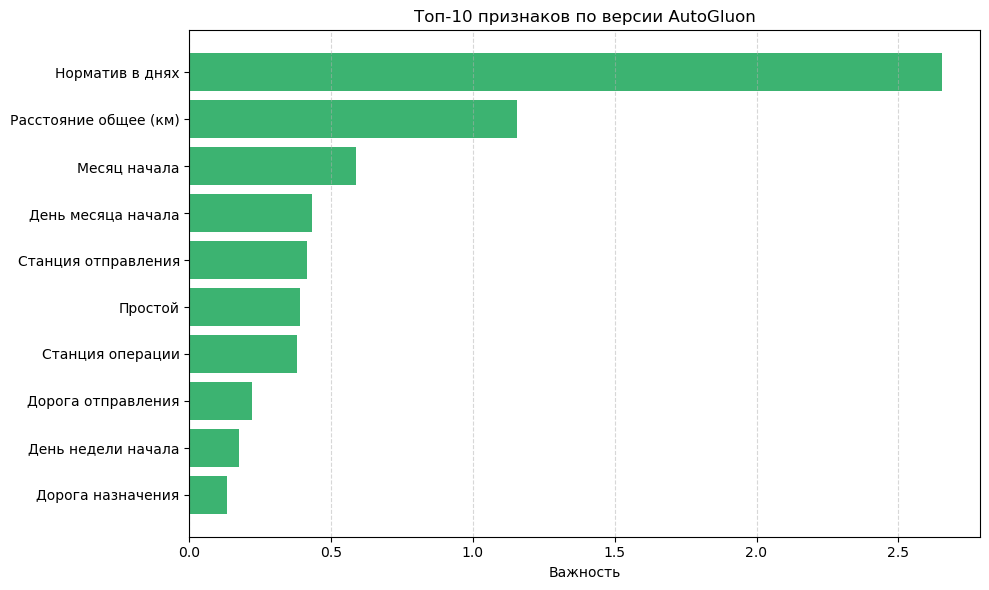

In [69]:
import matplotlib.pyplot as plt
import pandas as pd

# получаем важность признаков
fi = predictor.feature_importance(data=test_data)

# если это Series — преобразуем в DataFrame
if isinstance(fi, pd.Series):
    fi = fi.reset_index()
    fi.columns = ['Feature', 'Importance']
else:
    fi = fi.reset_index().rename(columns={"index": "Feature"})

# берём топ-15
top_n = 10
fi_top = fi.sort_values("importance", ascending=False).head(top_n)

# строим график
plt.figure(figsize=(10, 6))
plt.barh(fi_top["Feature"], fi_top["importance"], color='mediumseagreen')
plt.xlabel("Важность")
plt.title(f"Топ-{top_n} признаков по версии AutoGluon")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [70]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from itertools import product

# копия данных
X = df.drop(columns=["Срок доставки факт"])
y = df["Срок доставки факт"]

# train/test выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Категориальные признаки
cat_cols = X_train.select_dtypes(include="object").columns.tolist()

# Pool с метками категорий
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

# Сетка параметров
param_grid = {
    "depth": [4, 6, 8],
    "learning_rate": [0.03, 0.1],
    "iterations": [500, 1000],
}

# Перебор всех комбинаций
best_mae = float("inf")
best_params = None
best_model = None

for depth, lr, iters in product(param_grid["depth"], param_grid["learning_rate"], param_grid["iterations"]):
    model = CatBoostRegressor(
        depth=depth,
        learning_rate=lr,
        iterations=iters,
        random_state=42,
        verbose=0
    )
    model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50, verbose=0)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"depth={depth}, lr={lr}, iters={iters} → MAE: {mae:.4f}")

    if mae < best_mae:
        best_mae = mae
        best_params = {"depth": depth, "learning_rate": lr, "iterations": iters}
        best_model = model

print("\n🏆 Лучшая модель:")
print(f"Параметры: {best_params}")
print(f"MAE на тесте: {best_mae:.4f}")


depth=4, lr=0.03, iters=500 → MAE: 2.6073
depth=4, lr=0.03, iters=1000 → MAE: 2.5433
depth=4, lr=0.1, iters=500 → MAE: 2.4697
depth=4, lr=0.1, iters=1000 → MAE: 2.4297
depth=6, lr=0.03, iters=500 → MAE: 2.5231
depth=6, lr=0.03, iters=1000 → MAE: 2.4512
depth=6, lr=0.1, iters=500 → MAE: 2.4572
depth=6, lr=0.1, iters=1000 → MAE: 2.4572
depth=8, lr=0.03, iters=500 → MAE: 2.4483
depth=8, lr=0.03, iters=1000 → MAE: 2.3538
depth=8, lr=0.1, iters=500 → MAE: 2.3189
depth=8, lr=0.1, iters=1000 → MAE: 2.2768

🏆 Лучшая модель:
Параметры: {'depth': 8, 'learning_rate': 0.1, 'iterations': 1000}
MAE на тесте: 2.2768
